In [1]:
import os
import sys
import scipy.io
from scipy import signal
from libs import util_matlab as umatlab
import tensorflow as tf
import numpy as np
import statistics, math
from libs import datasets, dataset_utils, utils
import datetime
import time
#from matplotlib import pyplot as plt
#import wave
#sys.path.append(os.path.join(os.path.dirname(os.path.abspath('.')), 'computeDescriptorsDir'))
#import  utilFunctions as UF
import struct
from scipy.io.wavfile import write, read

/Users/alfonso/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/alfonso/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from __future__ import print_function

# We'll need numpy for some mathematical operations
import numpy as np

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

In [3]:
# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

In [4]:
INT16_FAC = (2**15)-1
INT32_FAC = (2**31)-1
INT64_FAC = (2**63)-1
norm_fact = {'int16':INT16_FAC, 'int32':INT32_FAC, 'int64':INT64_FAC,'float32':1.0,'float64':1.0}


def wavread(filename):
	"""
	Read a sound file and convert it to a normalized floating point array
	filename: name of file to read
	returns fs: sampling rate of file, x: floating point array
	"""

	if (os.path.isfile(filename) == False):                  # raise error if wrong input file
		raise ValueError("Input file is wrong")

	fs, x = read(filename)

	if (len(x.shape) !=1):                                   # raise error if more than one channel
		raise ValueError("Audio file should be mono")

	if (fs !=44100):                                         # raise error if more than one channel
		raise ValueError("Sampling rate of input sound should be 44100")

	#scale down and convert audio into floating point number in range of -1 to 1
	x = np.float32(x)/norm_fact[x.dtype.name]
	return fs, x



In [5]:
%matplotlib notebook
plt.style.use('ggplot')

In [36]:
resources_dir = "/Users/alfonso/code/violinDemos/ViolinTrainer/resources/"
resource = [
            'Scarlett_MyViolin', 
            'Scarlett_MyViolin', 
            'Scarlett_MyViolin', 
            'Scarlett_MyViolin', 
            #'Scarlett_V1',
            #'MacMic_MyViolin',
            #'MacMic_MyViolin',
            #'MacMic_MyViolin',
            #'MacMic_V2',
            #'MacMic_ViolinYamaha'
           ]
filenames = [
    ['BackNoiseMaia', 'EString_Long', 'AString_Long', 'DString_Long', 'GString_Long'],
    ['BackNoiseMaia', 'EStringScaleVibrato', 'AStringScaleVibrato', 'DStringScaleVibrato', 'GStringScaleVibrato'],
    ['BackNoiseMaia', 'EStringGliss', 'AStringGliss', 'DStringGliss', 'GStringGliss'],
    ['BackNoiseMaia', 'EStringScaleDetache', 'AStringScaleDetache', 'DStringScaleDetache', 'GStringScaleDetache'],
    #['Silence', 'EString', 'AString', 'DString', 'GString'],
    #['Silence01', 'EString01', 'AString01', 'DString01', 'GString01'],
    #['BackNoiseMaia', 'EStringScaleVibrato', 'AStringScaleVibrato', 'DStringScaleVibrato', 'GStringScaleVibrato'],
    #['BackNoiseMaia', 'EStringGliss', 'AStringGliss', 'DStringGliss', 'GStringGliss'],
    #['Silence', 'EString', 'AString', 'DString', 'GString'],
    #['Silence01', 'EString01', 'AString01', 'DString01', 'GString01'],
]
n_classes = 5
windowSize = 512
hopSize = 128
fftPad=1
fftSize=windowSize*fftPad
window=np.blackman(fftSize)
window = window / sum(window)  # normalize analysis window
convImgLengthSecs=0.1
analSR = 44100 / hopSize
convImgLength = int( analSR * convImgLengthSecs )
#Read 2D spectrogram windows of 
#winLSecs = 0.1
#sr = 44100
#windowSize = int((winLSecs * sr) // 2 * 2)
# And we'll move our window by windowSize/2
#hopSize = windowSize // 2
#hopSize
convImgLength

34

In [45]:
# ------------- prepare dataset
Xs = []
ys = []
[n_recordings, n_strings] = np.array(filenames).shape


convImgLengthSecs=0.05
doSpecGram=False
        
for iRecording in range (0, n_recordings):
    for iString in range(0, n_strings):
        inputFile = resources_dir + resource[iRecording] + "/" + filenames[iRecording][iString] + '.wav'
        (fs, x) = wavread(inputFile)
        print(inputFile, ':', x.shape)
        #num_frames = int((len(x) - windowSize) / hopSize) + 1
        #pin = 0
        #for iFrame in range(0, num_frames):
        #    grain = x[pin: pin + windowSize]
        #    grainW=grain*np.blackman(fftSize)
        #    fft=np.fft.fft(grain)
        #    fftMag=np.abs(fft)
        #    fftMag=fftMag[0:int(fftSize/2)]
        #    fftMagdB=20*np.log10(fftMag)
        #    pin += hopSize  # advance sound pointer
        if doSpecGram:
            windowSize = 256 
            zeropadding = 2
            fftSize = windowSize * zeropadding
            hopSize = nperseg // 4
            f, t, Sxx = signal.spectrogram(x, fs, window=('blackman'), nperseg=windowSize, 
                                   noverlap = hopSize, nfft = fftSize, 
                                   mode='magnitude', scaling = 'spectrum' )
            SxxdB = 20*np.log10(Sxx)
            auxavg = np.average(SxxdB, axis=0)
            SxxdBNorm = SxxdB / auxavg
        else:
            hopSize = 128
            fftSize = 1024
            # Mel-scaled power (energy-squared) spectrogram
            Sxx = librosa.feature.melspectrogram(x, sr=fs, n_mels=128, n_fft=fftSize, 
                                                 hop_length=hopSize)
            #n_fft=2048, hop_length=512,power=2.0,
            # Convert to log scale (dB). We'll use the peak power as reference.
            SxxdB = librosa.logamplitude(Sxx, ref_power=np.max)
            auxavg = np.average(SxxdB, axis=0)
            SxxdBNorm = SxxdB / auxavg
        
        analSR = fs / hopSize
        convImgLength = int( analSR * convImgLengthSecs )
        conv_hop = convImgLength //2
        
        n_conv_hops = (SxxdB.shape[1]) // conv_hop
        n_conv_hops = int(n_conv_hops) - 1        #??
        for img_i in range(n_conv_hops):
            # Creating our sliding window
            frames = SxxdBNorm[:, (img_i * conv_hop):(img_i * conv_hop + convImgLength)]
            Xs.append(frames[..., np.newaxis])
            ys.append(iString)
print("Xs.shape:", np.array(Xs).shape, ", ys.shape:", np.array(ys).shape)
print("convImgLength:", convImgLength)
Xs = np.array(Xs)
ys = np.array(ys)
ds = datasets.Dataset(Xs=Xs, ys=ys, split=[0.8, 0.1, 0.1], one_hot=True, n_classes=n_classes)

/Users/alfonso/anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/BackNoiseMaia.wav : (2097152,)
/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/EString_Long.wav : (9729024,)
/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/AString_Long.wav : (11447296,)
/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/DString_Long.wav : (11352064,)
/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/GString_Long.wav : (12371456,)
/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/BackNoiseMaia.wav : (2097152,)
/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/EStringScaleVibrato.wav : (2826240,)
/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/AStringScaleVibrato.wav : (2908160,)
/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/DStringScaleVibrato.wav : (3244544,)
/Users/alfonso/code/violinDemos/Violin

In [46]:
print(Xs.shape)
# create convNet
# ---------- create ConvNet
tf.reset_default_graph()

X = tf.placeholder(name='X', shape=(None, Xs.shape[1], Xs.shape[2], Xs.shape[3]), dtype=tf.float32)
Y = tf.placeholder(name='Y', shape=(None, n_classes), dtype=tf.float32)

# TODO:  Explore different numbers of layers, and sizes of the network
n_filters = [10, 10]
height_filters = [Xs.shape[1],1]
width_filters = [1, Xs.shape[2]]
padding = 'VALID'

# Now let's loop over our n_filters and create the deep convolutional neural network
H = X
for layer_i, n_filters_i in enumerate(n_filters):
    # Let's use the helper function to create our connection to the next layer:
    # TODO: explore changing the parameters here:
    H, W = utils.conv2d(
        H, n_filters_i, k_h=height_filters[layer_i], k_w=width_filters[layer_i], d_h=1, d_w=1,
        name=str(layer_i), padding=padding)

    # And use a nonlinearity
    # TODO: explore changing the activation here:
    H = tf.nn.softplus(H)

    # Just to check what's happening:
    print(H.get_shape().as_list())

# Connect the last convolutional layer to a fully connected network
fc, W = utils.linear(H, n_output=50, name="fcn1", activation=tf.nn.relu)
# fc2, W = utils.linear(fc, n_output=50, name="fcn2", activation=tf.nn.relu)
# fc3, W = utils.linear(fc, n_output=10, name="fcn3", activation=tf.nn.relu)

# And another fully connceted network, now with just n_classes outputs, the number of outputs that our
# one hot encoding has
Y_pred, W = utils.linear(fc, n_output=n_classes, name="pred", activation=tf.nn.sigmoid)

(73995, 128, 17, 1)
[None, 1, 17, 10]
[None, 1, 1, 10]


In [47]:
# pre-train ConvNet
loss = tf.squared_difference(Y_pred, Y)
cost = tf.reduce_mean(tf.reduce_sum(loss, 1))
predicted_y = tf.argmax(Y_pred, 1)
actual_y = tf.argmax(Y, 1)
correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Explore these parameters: (TODO)
batch_size = 100

# Create a session and init!
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.initialize_all_variables())

In [48]:
# train ConvNet
# Now iterate over our dataset n_epoch times
n_epochs = 100
# Now iterate over our dataset n_epoch times
for epoch_i in range(n_epochs):
    if epoch_i % 10 == 0:
        print('Epoch: ', epoch_i)
    # Train
    this_accuracy = 0
    its = 0
    accByString=[0]*5
    itsByString=[0]*5
    counter=0
    # Do our mini batches:
    for Xs_i, ys_i in ds.train.next_batch(batch_size):
        #print('loop:',counter)
        counter +=1
        # Note here: we are running the optimizer so
        # that the network parameters train!
        [batch_prediction, batch_accuracy, _] = sess.run([Y_pred, accuracy, optimizer], feed_dict={
            X: Xs_i, Y: ys_i})
        #compute accuracy for each string
        this_accuracy += batch_accuracy
        #compute accuracy for each string
        origString = np.argmax(ys_i,1)
        predString= np.argmax(batch_prediction,1)
        for iString in range(5):
            idx = np.where(origString==iString)
            idx=idx[0]
            if len(idx):
                sumByString=np.sum(np.equal(origString[idx],predString[idx]).astype(float))
                #print(avg)
                #if not math.isnan(avg):
                accByString[iString]+=sumByString
                itsByString[iString]+=len(idx)
                #else:
                #    print('len(idx):', len(idx))
                 #   print('idx:', idx)
                    
        its += 1
        #print("minibatch.train:",its)
    if epoch_i % 10 == 0:
        print('Training accuracy (batch): ', this_accuracy, '/', its, '=', this_accuracy/its)
        for iString in range(5):
            print("accByString[", iString, "]:", accByString[iString],'/',itsByString[iString])

    # Validation (see how the network does on unseen data).
    this_accuracy = 0
    its = 0

    # Do our mini batches:
    for Xs_i, ys_i in ds.valid.next_batch(batch_size):
        # Note here: we are NOT running the optimizer!
        # we only measure the accuracy!
        this_accuracy += sess.run(accuracy, feed_dict={
            X: Xs_i, Y: ys_i})
        its += 1
        #print("minibatch.valid:",its)
    if epoch_i % 10 == 0:
        print('Validation accuracy (batch): ', this_accuracy,'/',its, '=', this_accuracy/its)

Epoch:  0
Training accuracy (batch):  376.394583892 / 592 = 0.63580166198
accByString[ 0 ]: 4181.0 / 6568
accByString[ 1 ]: 9436.0 / 11808
accByString[ 2 ]: 7985.0 / 13184
accByString[ 3 ]: 4683.0 / 13181
accByString[ 4 ]: 11351.0 / 14455
Validation accuracy (batch):  56.8199999928 / 74 = 0.767837837741
Epoch:  10
Training accuracy (batch):  563.84791851 / 592 = 0.952445808295
accByString[ 0 ]: 6286.0 / 6568
accByString[ 1 ]: 11398.0 / 11808
accByString[ 2 ]: 12350.0 / 13184
accByString[ 3 ]: 12314.0 / 13181
accByString[ 4 ]: 14033.0 / 14455
Validation accuracy (batch):  70.1300002933 / 74 = 0.947702706666
Epoch:  20
Training accuracy (batch):  568.947503388 / 592 = 0.961059971939
accByString[ 0 ]: 6368.0 / 6568
accByString[ 1 ]: 11452.0 / 11808
accByString[ 2 ]: 12519.0 / 13184
accByString[ 3 ]: 12430.0 / 13181
accByString[ 4 ]: 14122.0 / 14455
Validation accuracy (batch):  70.0700003505 / 74 = 0.946891896628
Epoch:  30
Training accuracy (batch):  575.358754456 / 592 = 0.971889787933


In [40]:
# post-train ConvNet
now = datetime.datetime.now()
save_path = saver.save(sess, "./models/string_convnet_" + "MelSpec_fftS512_ffthop128"+ "_" + now.strftime("%Y%m%d_%H%M") + ".ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./models/string_convnet_MelSpec_fftS512_ffthop128_20170509_1814.ckpt


Predict an input file

In [54]:
#path params
path = './models/'
#model_name = 'string_convnet_scarlettGliss_20170417_1503' #string_convnet_20170414_0019' #string_convnet_20170413_2242'
model_name = 'string_convnet_MelSpec_fftS512_ffthop128_20170509_1814'
predictionOPStr = 'pred/activationOperationForOutput'  # 'pred/Sigmoid'

#load graph and variables
tf.reset_default_graph()
saver = tf.train.import_meta_graph(path + model_name + '.ckpt.meta')
graph = tf.get_default_graph()
session = tf.Session()
saver.restore(session, path + model_name + '.ckpt')

#get input, output and operation to run
net_input = graph.get_tensor_by_name('X:0')
predictionOP = graph.get_operation_by_name(predictionOPStr)
outputTensor = graph.get_tensor_by_name(predictionOPStr + ':0')
#accuracy = graph.get_operation_by_name('Mean_1')
windowSize = net_input.get_shape().as_list()[2]
windowSize

17

In [56]:
# load recording
Xs_test = []
ys_test = []
iRecording = 0 
iString = 2
inputFile = resources_dir + resource[iRecording] + "/" + filenames[iRecording][iString] + '.wav'
(fs, x) = wavread(inputFile)
print(inputFile, ':', x.shape)
hopSize = 128
fftSize = 1024
analSR = fs / hopSize
convImgLength = int( analSR * convImgLengthSecs )
conv_hop = convImgLength //2

# Mel-scaled power (energy-squared) spectrogram
Sxx = librosa.feature.melspectrogram(x, sr=fs, n_mels=128, n_fft=fftSize, 
                                     hop_length=hopSize)
#n_fft=2048, hop_length=512,power=2.0,
# Convert to log scale (dB). We'll use the peak power as reference.
SxxdB = librosa.logamplitude(Sxx, ref_power=np.max)
auxavg = np.average(SxxdB, axis=0)
SxxdBNorm = SxxdB / auxavg

n_conv_hops = (SxxdB.shape[1]) // conv_hop
n_conv_hops = int(n_conv_hops) - 1        #??
for img_i in range(n_conv_hops):
    # Creating our sliding window
    frames = SxxdBNorm[:, (img_i * conv_hop):(img_i * conv_hop + convImgLength)]
    Xs_test.append(frames[..., np.newaxis])
    ys_test.append(iString)
Xs_test = np.array(Xs_test)
ys_test = np.array(ys_test)
print("Xs_test.shape:", np.array(Xs_test).shape, ", ys_test.shape:", np.array(ys_test).shape)
print("convImgLength:", convImgLength)


/Users/alfonso/anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/AString_Long.wav : (11447296,)
Xs_test.shape: (11178, 128, 17, 1) , ys_test.shape: (11178,)
convImgLength: 17


In [57]:
[ _, one_hot_prediction]=session.run([predictionOP, outputTensor], feed_dict={net_input:Xs_test})
prediction = np.argmax(one_hot_prediction, axis=1)
test_correct_prediction = prediction == ys_test
test_accuracy= np.mean(test_correct_prediction)
print("accuracy: ", test_accuracy)

accuracy:  0.981928788692


<IPython.core.display.Javascript object>


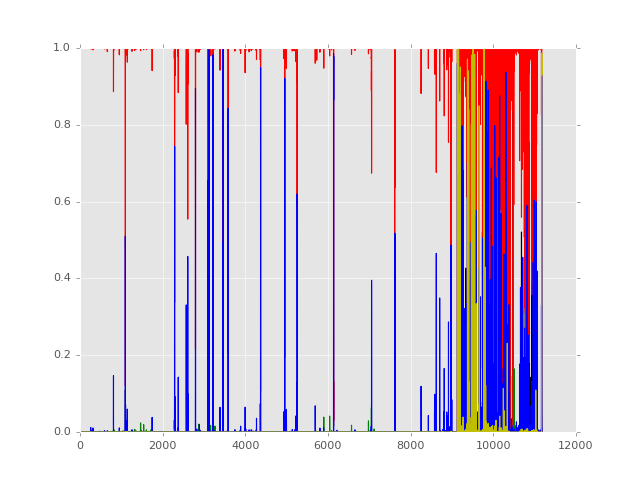

In [90]:
COLORS = ('k','g','r','b','y') #,'y','k','w') 'c', 'm'
for i in range(0,len(COLORS)):
    plt.plot(one_hot_prediction[:,i], color=COLORS[i])

In [69]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

<IPython.core.display.Javascript object>


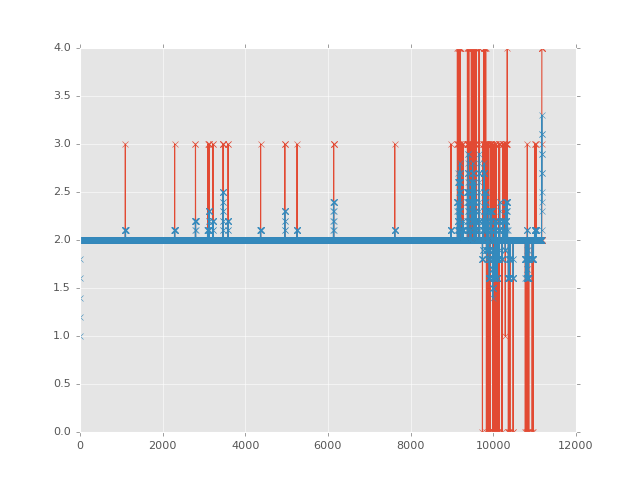

In [82]:
#filtered = lowess(prediction, range(0,len(prediction)), is_sorted=True, frac=0.025, it=0)
filtered = smooth(prediction,10) # window size 51, polynomial order 3
plt.plot(prediction,'x-')
#plt.plot(filtered,'x-')

In [76]:
frame=prediction[9120:9220]
np.std(frame)
np.mean(frame)

2.27

0.014512471655328799